In [222]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import defaultdict

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [223]:
#Import Dataset
df = pd.read_csv('Mode_Craft_Ecommerce_Data - Online_Retail.csv', dtype={'InvoiceNo': str}, low_memory=False)
df.index = pd.to_datetime(df.InvoiceDate)
df = df.dropna(how='all')
df.tail(10)

C:\Users\rajit\AppData\Local\Temp\ipykernel_1692\2999756280.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.InvoiceDate)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,,
2011-12-08 19:26:00,C581468,22098,BOUDOIR SQUARE TISSUE BOX,-12,12/8/11 19:26,0.39,13599.0,United Kingdom
2011-12-08 19:26:00,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,12/8/11 19:26,2.10,13599.0,United Kingdom
2011-12-08 19:28:00,C581470,23084,RABBIT NIGHT LIGHT,-4,12/8/11 19:28,2.08,17924.0,United Kingdom
2011-12-09 09:27:00,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/11 9:27,2.08,16446.0,United Kingdom
2011-12-09 09:57:00,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,12/9/11 9:57,1.95,14397.0,United Kingdom
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/11 9:57,0.83,14397.0,United Kingdom
2011-12-09 10:28:00,C581499,M,Manual,-1,12/9/11 10:28,224.69,15498.0,United Kingdom
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/11 11:57,10.95,15311.0,United Kingdom
2011-12-09 11:58:00,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/11 11:58,1.25,17315.0,United Kingdom


In [224]:
#Create Columns
def create_features(df):
    """
    Create time series features based on time series index.
    Revenue (Quantity x Unit Price)
    Day of Week

    Weekday or Weekend
    Quarter
    Product Name 
    """
    df = df.copy()
    df['revenue'] = df['Quantity'] * df['UnitPrice']
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df.index.dayofweek >= 5
    df['InvoiceDate'] = df.index
    return df

df = create_features(df)

df.tail(10)


# fig, ax = plt.subplots(figsize=(10, 8))
# sns.boxplot(data=df, x='InvoiceDate', y='Revenue')
# ax.set_title('MW by Hour')
# plt.show()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,dayofyear,quarter,is_weekend
InvoiceDate,,,,,,,,,,,,
2011-12-08 19:26:00,C581468,22098,BOUDOIR SQUARE TISSUE BOX,-12,2011-12-08 19:26:00,0.39,13599.0,United Kingdom,-4.68,342,4,False
2011-12-08 19:26:00,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,2011-12-08 19:26:00,2.10,13599.0,United Kingdom,-21.00,342,4,False
2011-12-08 19:28:00,C581470,23084,RABBIT NIGHT LIGHT,-4,2011-12-08 19:28:00,2.08,17924.0,United Kingdom,-8.32,342,4,False
2011-12-09 09:27:00,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.60,343,4,False
2011-12-09 09:57:00,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom,-23.40,343,4,False
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,343,4,False
2011-12-09 10:28:00,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,343,4,False
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,343,4,False
2011-12-09 11:58:00,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-6.25,343,4,False


<Axes: title={'center': 'Invoice vs Revenue'}, xlabel='InvoiceDate', ylabel='revenue'>

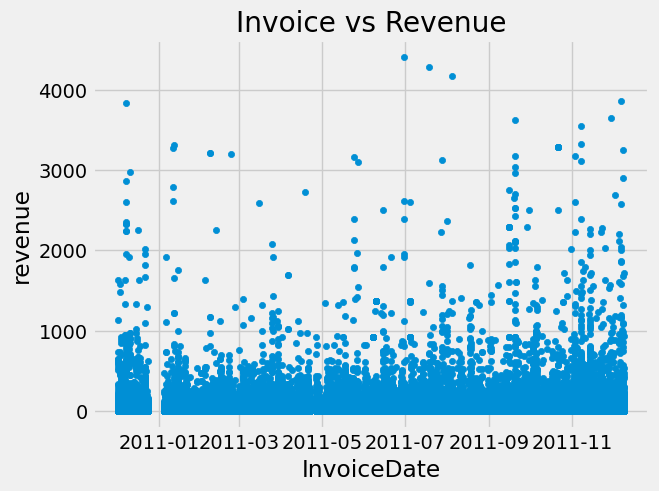

In [225]:
#Cleaning

# Step 1: Remove rows with UnitPrice == 0
df = df[df['UnitPrice'] != 0]

# Step 2: Build cancel_map 
cancel_map = defaultdict(set)

for _, row in df.iterrows():
    invoice = (str)(row['InvoiceNo'])
    customer_id = row['CustomerID']
    if (invoice).startswith('C'):
        cancel_map[customer_id].add(row['StockCode'])

# Step 3: Remove rows where (InvoiceNo, StockCode) match the cancelled pair
def is_cancelled_pair(row):
    customer_id = row['CustomerID']
    stock = row['StockCode']
    return customer_id in cancel_map and stock in cancel_map[customer_id]

df = df[~df.apply(is_cancelled_pair, axis=1)]

# Step 4: Remove cancellation rows and InvoiceNo with "B"
df = df[~df['InvoiceNo'].str.startswith('C')]
df = df[~df['InvoiceNo'].str.contains('B', case=False)]
# 0.1% and 99.9% bounds
low_q = df['revenue'].quantile(0.00001)
high_q = df['revenue'].quantile(0.99999)

# Filter only extreme outliers
df = df[(df['revenue'] >= low_q) & (df['revenue'] <= high_q)]



df.describe()
df.plot.scatter(x='InvoiceDate', y='revenue',title='Invoice vs Revenue')


<Axes: title={'center': 'Invoice vs Revenue'}, xlabel='hours', ylabel='revenue'>

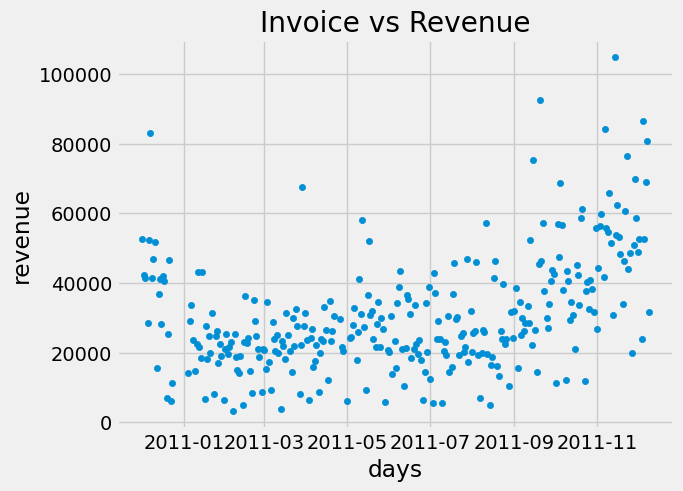

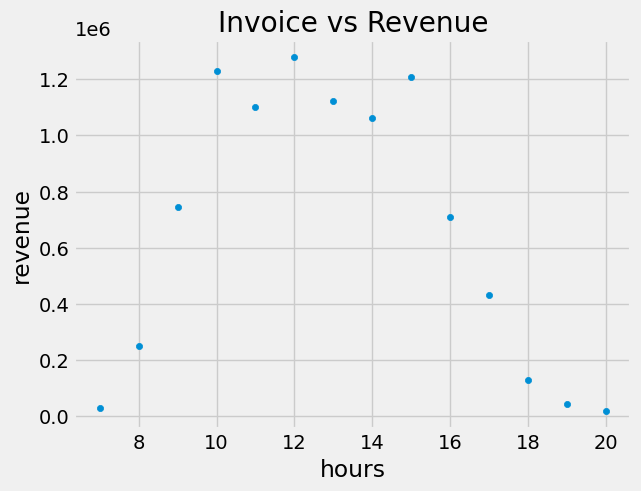

In [226]:
#New Dataframes

df['days'] = df['InvoiceDate'].dt.date
daily_revenue_df = df.groupby('days')['revenue'].sum().reset_index()

daily_revenue_df.plot.scatter( x='days', y='revenue',title='Invoice vs Revenue')

df['hours'] = df['InvoiceDate'].dt.hour
daily_hour_df = df.groupby('hours')['revenue'].sum().reset_index()

daily_hour_df.plot.scatter( x='hours', y='revenue',title='Invoice vs Revenue')

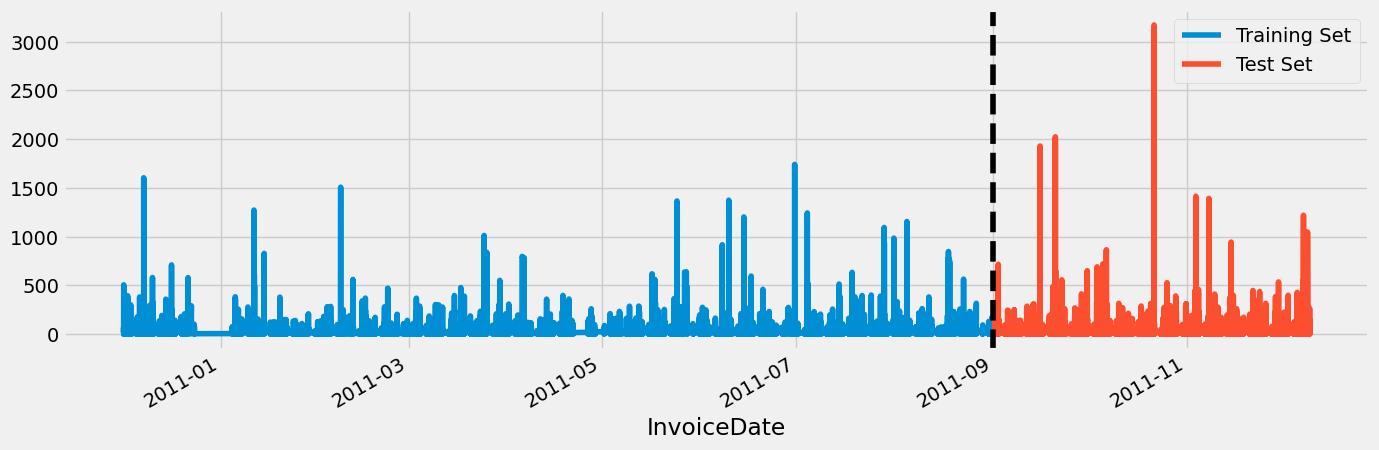

In [231]:
#Split Data

train = df.loc[df.index < '09-01-2011']
test = df.loc[df.index >= '09-01-2011']

fig, ax = plt.subplots(figsize=(15, 5))
train['revenue'].rolling(window=7).mean().plot(ax=ax, label='Training Set')
test['revenue'].rolling(window=7).mean().plot(ax=ax, label='Test Set')

ax.axvline('09-01-2011', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

